In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import matplotlib as mpl
# import chinese
font_name = "STKaiti"
mpl.rcParams['font.family']=font_name
mpl.rcParams['axes.unicode_minus']=False # in case minus sign is shown as box

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import xgboost
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, make_scorer

import progressbar
import warnings
warnings.filterwarnings('ignore')

# 1.0 Introduction
竞赛背景

太阳能被看作是最具有代表性的新能源，而其中太阳辐射是影响太阳能发电量的最主要因素。由于收到包括地理位置、太阳高度角、方位角、时角等时空要素，云量、云态、大气状态等气象要素的影响，太阳辐射预测一直是光伏发电量预测的关键。通过数值天气预报系统，可以通过对中尺度系统的模拟得到较为精细的辐射预报数据，然而预测信息中仍然存在冗余信息，单独使用辐射数据并不能精确地预报实际太阳辐射。



主办方简介：

  北京国能日新系统控制技术有限公司（简称：国能日新）是一家专业提供新能源软件产品及服务的高新技术企业，其拥有多项专业资质，具备自主研发、生产制造和全方位营销等综合能力，专注于为新能源企业在并网自动化、生产运营、企业信息化等方面提供优质的解决方案。通过专业的技术产品及全面的服务体系为新能源企业的更优发展提供技术保障。
  
### Mission
通过学习一段时间内的环境数据和对应的实际太阳辐指数，训练模型，通过给定某时间点预测的环境数据，预测该时间点的实际太阳辐射指数。
 
### Evalutaion
<img src="img/eval.png",width=270,height=60>
其中，n为样本数量， Pmi为实际太阳辐射指数；Ppi为预测太阳辐射指数。 

# 2.0 Data
- train_feature.csv 训练集特征数据，每个时刻1个数据，每天8个时刻。共17008。
- train_label.csv 训练集标签数据，每天1个数据，共2126个数据。
- test_feature.csv 测试集特征数据，每个时刻1个数据，每天8个时刻，共7320条数据，字段与训练集特征数据相同。

In [29]:
train_feature_df = pd.read_csv('train_feature.csv', low_memory=False)
train_label_df = pd.read_csv('train_label.csv', low_memory=False)
test_feature_df = pd.read_csv('test_feature.csv', low_memory=False)
print(train_feature_df.shape, train_label_df.shape, test_feature_df.shape)

(17008, 8) (2126, 2) (7320, 8)


In [3]:
train_feature_df[8:16]

,日期,时刻,辐照度,风速,风向,温度,湿度,气压
8,2,2,0,1.1,45,-5.2,46,69800
9,2,5,0,1.2,114,-5.8,52,69600
10,2,8,0,0.2,297,-8.9,59,69700
11,2,11,328,0.8,277,-3.9,41,69700
12,2,14,543,1.2,90,0.1,32,69400
13,2,17,198,1.4,69,1.2,30,69200
14,2,20,0,1.0,294,-3.8,45,69400
15,2,23,0,2.5,297,-5.4,48,69500


## 2.1 remake(merge) the data for each day
should be 7*8+2=58 cols

In [3]:
train_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = train_feature_df[train_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    train_feature_df_list.append(temp_df )

In [4]:
for i in range(8):
    train_label_df = train_label_df.merge(train_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))
train_label_df.head()

,日期,电场实际太阳辐射指数,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
0,1,0.108799,2,0,2.1,343,-7.2,51,69800,5,...,-3.5,40,69700,23,0,0.8,14,-4.8,42,69700
1,2,0.130559,2,0,1.1,45,-5.2,46,69800,5,...,-3.8,45,69400,23,0,2.5,297,-5.4,48,69500
2,3,0.114239,2,0,2.9,278,-7.4,58,69500,5,...,-3.8,30,69500,23,0,0.8,140,-3.8,29,69500
3,4,0.081599,2,0,0.3,90,-6.1,38,69500,5,...,-3.0,21,69100,23,0,0.8,270,-6.3,26,69200
4,5,0.212158,2,0,1.4,231,-9.9,33,69100,5,...,-6.1,26,69200,23,0,1.1,63,-7.5,28,69300


In [5]:
train_label_df.describe()

,日期,电场实际太阳辐射指数,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
count,2126.000000,2126.000000,2126.0,2126.0,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.0,...,2126.000000,2126.000000,2126.000000,2126.0,2126.0,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,1063.500000,0.463466,2.0,0.0,3.648024,163.967545,0.854186,47.563500,68781.890875,5.0,...,5.281891,37.987770,68629.868297,23.0,0.0,4.099153,162.804798,2.717215,44.065851,68786.124177
std,613.867657,0.258085,0.0,0.0,2.483166,98.524982,9.283157,21.477177,2845.692125,0.0,...,9.985961,19.432461,2834.373329,0.0,0.0,2.695404,99.576600,9.447207,20.992153,2844.596170
min,1.000000,0.000000,2.0,0.0,0.000000,0.000000,-25.100000,6.000000,52600.000000,5.0,...,-21.600000,3.000000,52500.000000,23.0,0.0,0.000000,0.000000,-23.700000,5.000000,52700.000000
25%,532.250000,0.287863,2.0,0.0,1.800000,88.000000,-6.600000,30.000000,68900.000000,5.0,...,-3.100000,23.000000,68700.000000,23.0,0.0,2.000000,86.250000,-4.900000,27.000000,68825.000000
50%,1063.500000,0.428083,2.0,0.0,3.200000,113.000000,-0.200000,43.000000,69400.000000,5.0,...,4.300000,33.000000,69200.000000,23.0,0.0,3.700000,111.000000,1.300000,40.000000,69400.000000
75%,1594.750000,0.620505,2.0,0.0,4.800000,270.000000,8.975000,66.000000,69800.000000,5.0,...,13.375000,51.000000,69600.000000,23.0,0.0,5.500000,270.000000,10.600000,60.000000,69800.000000
max,2126.000000,1.000000,2.0,0.0,13.800000,357.000000,22.600000,96.000000,71000.000000,5.0,...,30.200000,96.000000,71200.000000,23.0,0.0,15.700000,358.000000,27.700000,98.000000,71100.000000


## 2.2 delete some useless features
some data has only one values(unchanged), which are useless.

In [13]:
useless_labels = ['时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14','时刻_17', '时刻_20', '时刻_23','辐照度_2',
                  '辐照度_5','辐照度_23']
for label inuseless_labels:
    print(train_label_df[label].value_counts())

2    2126
Name: 时刻_2, dtype: int64
5    2126
Name: 时刻_5, dtype: int64
8    2126
Name: 时刻_8, dtype: int64
11    2126
Name: 时刻_11, dtype: int64
14    2126
Name: 时刻_14, dtype: int64
17    2126
Name: 时刻_17, dtype: int64
20    2126
Name: 时刻_20, dtype: int64
23    2126
Name: 时刻_23, dtype: int64
0    2126
Name: 辐照度_2, dtype: int64
0    2126
Name: 辐照度_5, dtype: int64
0    2126
Name: 辐照度_23, dtype: int64


In [16]:
useless_labels.append('日期')
fcol = [c for c in train_label_df.columns if c not in useless_labels]
train_df = train_label_df[fcol]

## 2.3 find outliers

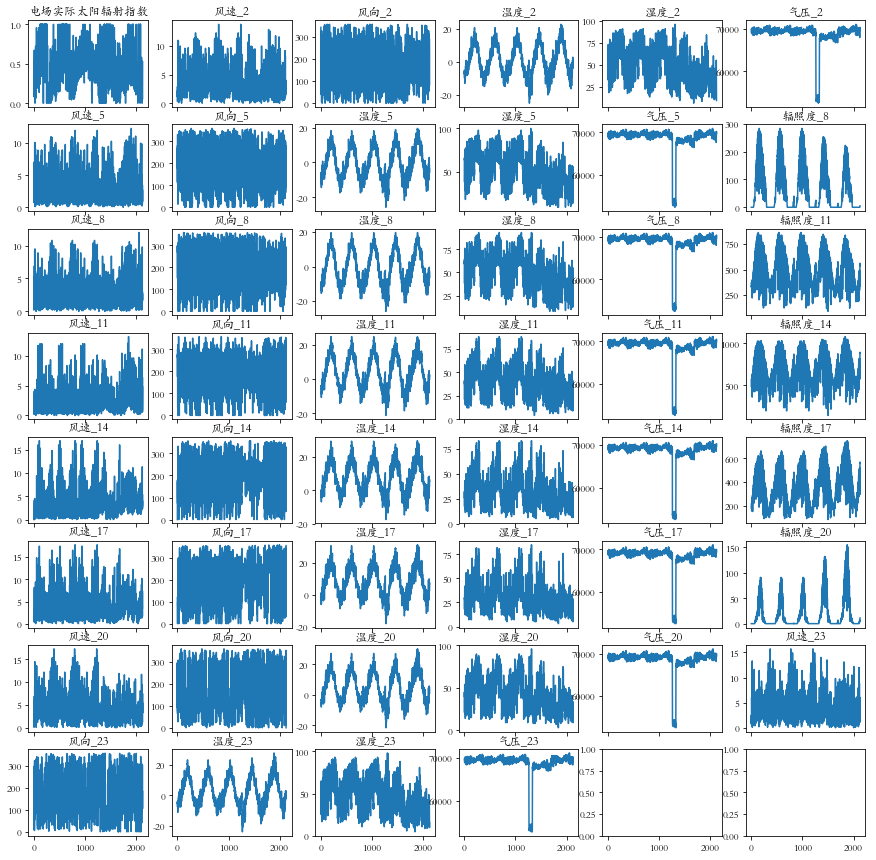

In [58]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=8, ncols=6, sharex=True,figsize=(15, 15))
plot_id = 0
for label in train_df.columns:
    col = int(plot_id/6)
    row = plot_id - col*6
    ax = axs[col][row]
    ax.plot(train_df[label])
    ax.set_title(label)
    plot_id += 1

- there are some data have extremely low values for each of the pressures
- the other data seems good

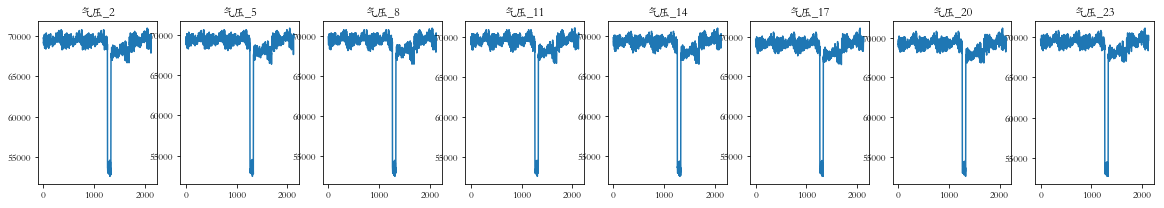

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharex=True,figsize=(20, 3))
plot_id = 0
for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    ax = axs[plot_id]
    ax.plot(train_df[label])
    ax.set_title(label)
    plot_id += 1

#### they are index from 1262 to 1329 (data from 1263 to 1330 )

In [182]:
for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    train_df[label][1262:1330] = train_df[label][1262:1330] - (train_df[label][1262] - train_df[label][1261])

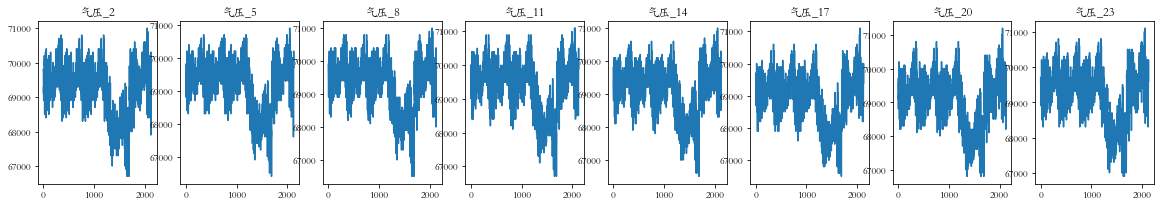

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharex=True,figsize=(20, 3))
plot_id = 0
for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    ax = axs[plot_id]
    ax.plot(train_df[label])
    ax.set_title(label)
    plot_id += 1                                

#### the values of the fourth(I suppose) is still a little too low

## 2.4 period
there are total 2126 days of data, but five picks. As officially explained, there are five observations to get the data.

In [112]:
idxss = []
print('the position of the max values of some cols are:')
for i in [8,11,14,17,20]:
    for k in ['温度_','湿度_', '辐照度_']:
        label = k + str(i)
        idxs = []
        for j in range(5):
            idx = train_df[label][425*j:425*(j+1)].argmax()
            idxs.append(idx)
        idxss.append(idxs)
        print('  ', label, '  : ', idxs)

the position of the max values of some cols are:
   温度_8   :  [199, 602, 1034, 1460, 1890]
   湿度_8   :  [280, 683, 1115, 1312, 1932]
   辐照度_8   :  [155, 558, 990, 1406, 1838]
   温度_11   :  [199, 602, 1034, 1460, 1887]
   湿度_11   :  [280, 683, 1115, 1312, 1932]
   辐照度_11   :  [137, 540, 972, 1406, 1838]
   温度_14   :  [198, 601, 1033, 1458, 1887]
   湿度_14   :  [280, 683, 1115, 1312, 1929]
   辐照度_14   :  [191, 594, 1026, 1384, 1838]
   温度_17   :  [198, 601, 1033, 1460, 1890]
   湿度_17   :  [237, 640, 1072, 1312, 1929]
   辐照度_17   :  [188, 591, 1023, 1453, 1875]
   温度_20   :  [198, 601, 1033, 1459, 1890]
   湿度_20   :  [237, 640, 1072, 1313, 1929]
   辐照度_20   :  [179, 582, 1014, 1439, 1875]


In [113]:
print('the distance between the maximums are :')
for i in idxss:
    print('    ', i[1]-i[0], i[2]-i[1], i[3]-i[2], i[4]-i[3])

the distance between the maximums are :
     403 432 426 430
     403 432 197 620
     403 432 416 432
     403 432 426 427
     403 432 197 620
     403 432 434 432
     403 432 425 429
     403 432 197 617
     403 432 358 454
     403 432 427 430
     403 432 240 617
     403 432 430 422
     403 432 426 431
     403 432 241 616
     403 432 425 436


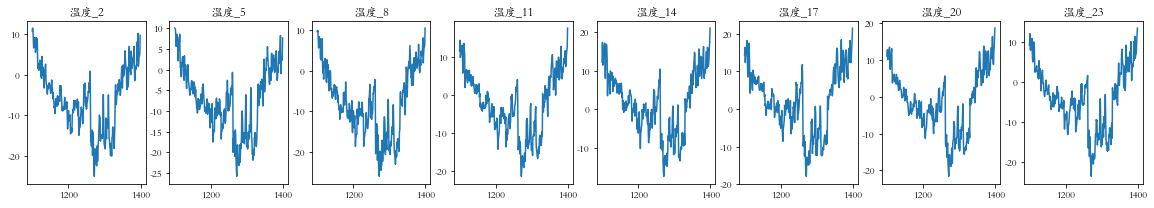

In [116]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharex=True,figsize=(20, 3))
plot_id = 0
for i in [2,5,8,11,14,17,20,23]:
    label = '温度_' + str(i)
    ax = axs[plot_id]
    ax.plot(train_df[label][1100:1400])
    ax.set_title(label)
    plot_id += 1          

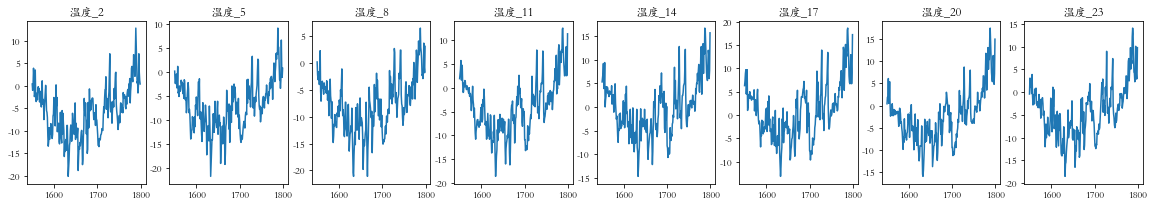

In [146]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharex=True,figsize=(20, 3))
plot_id = 0
for i in [2,5,8,11,14,17,20,23]:
    label = '温度_' + str(i)
    ax = axs[plot_id]
    ax.plot(train_df[label][1550:1800])
    ax.set_title(label)
    plot_id += 1   

#### so i suppose the fourth observation is from 1262 to 1689
- see from the '温度' col , there is a peak at the beginning and at the end, from which I analysis the data between the third and the fourth maximum, then I found 1262 be a reasonable beginning.
- for the end I tried a lot, but most of which won't work for the following analysis, finally I found 1689 best.

In [183]:
for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    mean_all = train_df[label][0:1262].mean()
    mean_4 = train_df[label][1262:1689].mean()
    print(label, ' : ', mean_all, mean_4, mean_all-mean_4)
    train_df[label][1262:1689] = train_df[label][1262:1689] + (mean_all-mean_4)

气压_2  :  69530.19017432646 68169.32084309134 1360.8693312351243
气压_5  :  69478.20919175912 68099.76580796253 1378.4433837965917
气压_8  :  69592.63074484945 68228.8056206089 1363.8251242405531
气压_11  :  69627.0206022187 68300.93676814988 1326.0838340688206
气压_14  :  69349.12836767036 68069.55503512881 1279.5733325415495
气压_17  :  69196.19651347068 67899.53161592507 1296.6648975456192
气压_20  :  69352.77337559429 68002.10772833724 1350.6656472570467
气压_23  :  69527.17908082409 68176.11241217799 1351.0666686461045


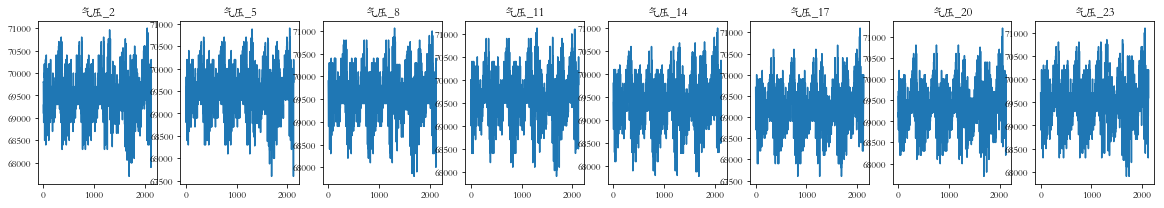

In [184]:
fig, axs = plt.subplots(nrows=1, ncols=8, sharex=True,figsize=(20, 3))
plot_id = 0
for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    ax = axs[plot_id]
    ax.plot(train_df[label])
    ax.set_title(label)
    plot_id += 1  

## 2.5 correlation of features

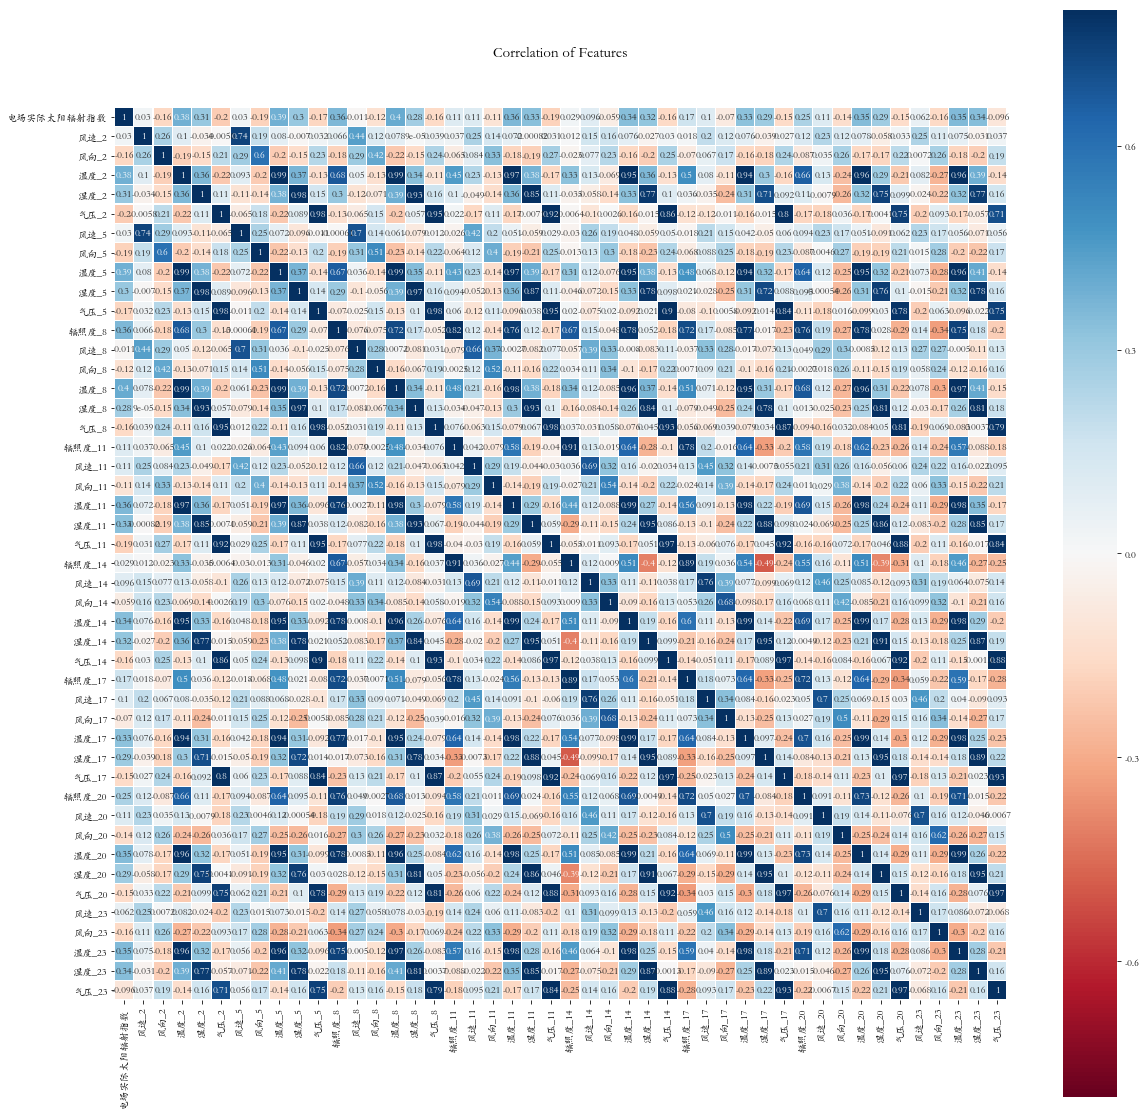

In [187]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=0.8, vmin=-0.8,
            square=True, cmap=colormap, linecolor='white', annot=True)

# summary of pre-process of data

In [6]:
useless_labels = ['时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14','时刻_17', '时刻_20', '时刻_23','辐照度_2',
                  '辐照度_5','辐照度_23']
useless_labels.append('日期')
fcol = [c for c in train_label_df.columns if c not in useless_labels]
train_df = train_label_df[fcol]

for i in [2,5,8,11,14,17,20,23]:
    label = '气压_' + str(i)
    train_df[label][1262:1330] = train_df[label][1262:1330] - (train_df[label][1262] - train_df[label][1261])
    mean_all = train_df[label][0:1262].mean()
    mean_4 = train_df[label][1262:1689].mean()
    train_df[label][1262:1689] = train_df[label][1262:1689] + (mean_all-mean_4)

In [7]:
train_df.to_csv('train_df.csv', index=False)

# 3. Feature engineer

In [3]:
train_df = pd.read_csv('train_df.csv', low_memory=False)
train_df.head()

,电场实际太阳辐射指数,风速_2,风向_2,温度_2,湿度_2,气压_2,风速_5,风向_5,温度_5,湿度_5,...,风速_20,风向_20,温度_20,湿度_20,气压_20,风速_23,风向_23,温度_23,湿度_23,气压_23
0,0.108799,2.1,343,-7.2,51,69800.0,3.6,279,-9.4,64,...,1.0,66,-3.5,40,69700.0,0.8,14,-4.8,42,69700.0
1,0.130559,1.1,45,-5.2,46,69800.0,1.2,114,-5.8,52,...,1.0,294,-3.8,45,69400.0,2.5,297,-5.4,48,69500.0
2,0.114239,2.9,278,-7.4,58,69500.0,3.1,270,-9.5,66,...,0.1,225,-3.8,30,69500.0,0.8,140,-3.8,29,69500.0
3,0.081599,0.3,90,-6.1,38,69500.0,2.1,177,-9.1,45,...,0.5,90,-3.0,21,69100.0,0.8,270,-6.3,26,69200.0
4,0.212158,1.4,231,-9.9,33,69100.0,1.5,203,-11.1,38,...,0.2,297,-6.1,26,69200.0,1.1,63,-7.5,28,69300.0


In [3]:
train_df.columns

Index(['电场实际太阳辐射指数', '风速_2', '风向_2', '温度_2', '湿度_2', '气压_2', '风速_5', '风向_5',
       '温度_5', '湿度_5', '气压_5', '辐照度_8', '风速_8', '风向_8', '温度_8', '湿度_8', '气压_8',
       '辐照度_11', '风速_11', '风向_11', '温度_11', '湿度_11', '气压_11', '辐照度_14',
       '风速_14', '风向_14', '温度_14', '湿度_14', '气压_14', '辐照度_17', '风速_17', '风向_17',
       '温度_17', '湿度_17', '气压_17', '辐照度_20', '风速_20', '风向_20', '温度_20', '湿度_20',
       '气压_20', '风速_23', '风向_23', '温度_23', '湿度_23', '气压_23'],
      dtype='object')

## 3.1 Prior knowledge

###  sun light
the expression of sun light (extraterrestrial solar illuminance) is (from https://en.wikipedia.org/wiki/Sunlight):
<img src="img/sunlight.png",width=350,height=60>
<img src="img/attenuation.png",width=130,height=60>
- because of Earth's elliptic orbit, it has a relation ship with the day. However even we can figure out the date with training set, we will not know their relatioship with the test set. So I think we can do nothing about the date.
- there is also the attenuation by Earth's atmosphere. I check the expression of attenuation is about [Beer Lambert Law](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law), from where we have :
<img src="img/bll.png",width=200,height=60>

###  the humidity
- the expression of relative humidity is ( over a flat surface of pure water at a given temperature):
<img src="img/humidity.png",width=80,height=60>
-  the pressure should be related to the humidity, but we cannot see such correlation from the correlation matrix.
- but may be there is a meaning if we get Pressure/Humidity.
- we have also [Gas Laws](https://en.wikipedia.org/wiki/Gas_laws):
<img src="img/gas.png",width=80,height=60>
- whatever the expression it used, we can say that the humidity has a positive relationship with the mass of water in air, which we saw can be related to the attenuation.

In [8]:
def gas_laws_col(temp_df):
    for i in [2,5,8,11,14,17,20,23]:
        label_final = 'gas_law_' + str(i)
        temp_df[label_final] = temp_df['气压_'+str(i)]/(temp_df['温度_'+str(i)] + 273.16)
    return temp_df

def relative_humidity_col(temp_df):
    for i in [2,5,8,11,14,17,20,23]:
        label_final = 'r_humidity_' + str(i)
        temp_df[label_final] = temp_df['气压_'+str(i)]/(temp_df['湿度_'+str(i)])
    return temp_df

def beer_and_attenuation_col(temp_df):
    for i in [2,5,8,11,14,17,20,23]:
        label_final = 'beer_' + str(i)
        temp_df[label_final] = 1/np.exp( - temp_df['湿度_'+str(i)]/100)
    for i in [8,11,14,17,20]:
        label_final = 'attenuation_' + str(i)
        temp_df[label_final] = temp_df['辐照度_'+str(i)]* temp_df['beer_' + str(i)]
    return temp_df

- the maximum of the irradiance of the day may be useful
- from the former tests, I found the humidity is an important feature for XGB. So I will take the max and the min of the humidity of the day

In [9]:
def max_irradiance_col(temp_df):
    labels = []
    for i in [8,11,14,17,20]:
        labels.append('辐照度_'+str(i))
    label_final = 'max_irradiance'
    temp_df[label_final] = temp_df[labels].max(axis=1)
    return temp_df

def max_humidity_col(temp_df):
    labels = []
    for i in [2,5,8,11,14,17,20,23]:
        labels.append('湿度_'+str(i))
    temp_df['max_humidity'] = temp_df[labels].max(axis=1)
    temp_df['min_humidity'] = temp_df[labels].min(axis=1)
    return temp_df

In [10]:
def add_new_features(temp_df):
    temp_df = gas_laws_col(temp_df)
    temp_df = relative_humidity_col(temp_df)
    temp_df = beer_and_attenuation_col(temp_df)
    temp_df = max_irradiance_col(temp_df)
    temp_df = max_humidity_col(temp_df)
    return temp_df

In [11]:
train_df = add_new_features(train_df)
train_df.to_csv('train_feature_added.csv', index=False)

## 3.2 Polynomial features
after sklearn method of polynomial features, we will have (n*(n-1)/2 + n + 1 ) features.


In [22]:
poly = sklearn.preprocessing.PolynomialFeatures(interaction_only=True)
X = poly.fit_transform(X)

However, there are too much features by this method, we need to choose within them.

In [14]:
def polynomial_feature_col(temp_df):
    for i in [8,11,14,17,20]:
        for j in ['风速_','风向_','温度_','湿度_','气压_','辐照度_']:
            for k in ['风速_','风向_','温度_','湿度_','气压_','辐照度_']:
                temp_df[j+k+str(i)] = temp_df[j+str(i)]*temp_df[k+str(i)]
        
    for i in [2,5,23]:
        for j in ['风速_','风向_','温度_','湿度_','气压_']:
            for k in ['风速_','风向_','温度_','湿度_','气压_']:
                temp_df[j+k+str(i)] = temp_df[j+str(i)]*temp_df[k+str(i)]
    return temp_df

In [15]:
train_df = polynomial_feature_col(train_df)

# 4.  Model XGBoosting

## 4.1 normalize data

In [19]:
fcol = [c for c in train_df.columns if c not in ['日期', '时刻_2', '时刻_5', '时刻_8', '时刻_11', '时刻_14',
                                             '时刻_17', '时刻_20', '时刻_23','辐照度_2', '辐照度_5','辐照度_23', '电场实际太阳辐射指数']]

X = train_df[fcol].values
y = train_df['电场实际太阳辐射指数']

In [20]:
# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)
X.shape, y.shape

((2126, 332), (2126,))

## 4.2 parameter analysis of XGBoosting

In [15]:
def loss_func(y_true, y_pred):
    diff = np.abs(y_true - y_pred).mean()
    return diff

my_score = make_scorer(loss_func, greater_is_better=False)

### 4.2.1 n_estimator
The number of trees (or rounds) in an XGBoost model is specified to the XGBClassifier or XGBRegressor class in the n_estimators argument. The default in the XGBoost library is 100

Best: -0.168656 using {'n_estimators': 40}
-0.169382 (0.001975) with: {'n_estimators': 20}
-0.168656 (0.002041) with: {'n_estimators': 40}
-0.169214 (0.002212) with: {'n_estimators': 60}
-0.170235 (0.002447) with: {'n_estimators': 80}


Text(0,0.5,'Neg Loss')

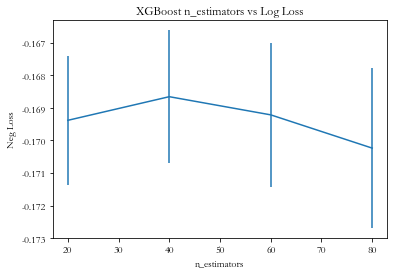

In [22]:
model = XGBRegressor()
n_estimators = range(20, 100, 20)
param_grid = dict(n_estimators=n_estimators)
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Neg Loss')

### 4.2.4 with eta (learning rate)

In [54]:
model = XGBRegressor()
eta = np.array([0.1,0.01,0.001])
n_estimators = [50, 100, 150]
max_depth = [2, 3, 4]
param_grid = dict(learning_rate=eta, max_depth=max_depth, n_estimators=n_estimators)
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   39.6s finished


Best: -0.167258 using {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}
-0.167744 (0.008439) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.1}
-0.167258 (0.008478) with: {'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1}
-0.167934 (0.008340) with: {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.1}
-0.167716 (0.008365) with: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}
-0.169155 (0.008189) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
-0.170581 (0.008231) with: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1}
-0.169927 (0.007246) with: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1}
-0.172685 (0.007074) with: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1}
-0.175839 (0.006877) with: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1}
-0.191075 (0.011083) with: {'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.01}
-0.180207 (0.010510) with: {'n_estimators': 100, 'm

## 4.3 train & predict

In [47]:
## xgboost training
xgb_up = xgboost.XGBRegressor(n_jobs=4,
                       n_estimators=500,
                       max_depth=3,
                       objective='reg:linear',
                       min_child_weight=2,
                       tree_method='gpu_hist',
                       silent= True)
xgb_up.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [48]:
def generate_color():
    color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: np.random.randint(0, 255), range(3)))
    return color

df = pd.DataFrame({'imp': xgb_up.feature_importances_, 'col':fcol})
df = df.sort_values(['imp','col'], ascending=[True, False])
data = [df]
for dd in data:  
    colors = []
    for i in range(len(dd)):
         colors.append(generate_color())
    data = [
        go.Bar(
        orientation = 'h',
        x=dd.imp,
        y=dd.col,
        name='Features',
        textfont=dict(size=20),
            marker=dict(
            color= colors,
            line=dict(
                color='#000000',
                width=0.5
            ),
            opacity = 0.87
        )
    )
    ]
    layout= go.Layout(
        title= 'Feature Importance of XGBOOST',
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis=dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )

    py.iplot(dict(data=data,layout=layout), filename='horizontal-bar')

# Test Dataset

In [26]:
test_feature_df = pd.read_csv('test_feature.csv', low_memory=False)
test_feature_df = test_feature_df.iloc[0:7296]
print('dates in test dataset is : ', test_feature_df.shape[0]/8)

dates in test dataset is :  912.0


In [27]:
# initalize the test label
index = np.arange(912)
columns = ['日期']
data = np.array([np.arange(1, 913)]).T
test_label_df = pd.DataFrame(data, index=index, columns=columns)

In [28]:
test_feature_df_list = []
for i in [2,5,8,11,14,17,20,23]:
    temp_df = test_feature_df[test_feature_df['时刻'] == i].add_suffix('_'+str(i))
    temp_df.rename(columns={'日期_'+str(i):'日期'}, inplace=True)
    test_feature_df_list.append(temp_df )
    
for i in range(8):
    test_label_df = test_label_df.merge(test_feature_df_list[i], left_on = '日期', right_on='日期', how='left', suffixes=('',''))

In [195]:
test_label_df.head()

,日期,时刻_2,辐照度_2,风速_2,风向_2,温度_2,湿度_2,气压_2,时刻_5,辐照度_5,...,温度_20,湿度_20,气压_20,时刻_23,辐照度_23,风速_23,风向_23,温度_23,湿度_23,气压_23
0,1,2,0,1.3,257,-8.6,34,68600,5,0,...,-6.3,19,68900,23,0,14.9,286,-8.7,21,69100
1,2,2,0,13.8,288,-10.7,28,69300,5,0,...,-6.8,16,69400,23,0,11.6,280,-9.4,20,69600
2,3,2,0,9.6,274,-12.1,24,69700,5,0,...,-4.1,9,69800,23,0,12.1,281,-7.0,11,70000
3,4,2,0,7.5,278,-10.3,15,70000,5,0,...,-3.9,14,69500,23,0,3.3,272,-6.1,20,69500
4,5,2,0,5.1,276,-8.1,16,69600,5,0,...,-1.0,20,68700,23,0,1.6,333,-2.9,24,68700


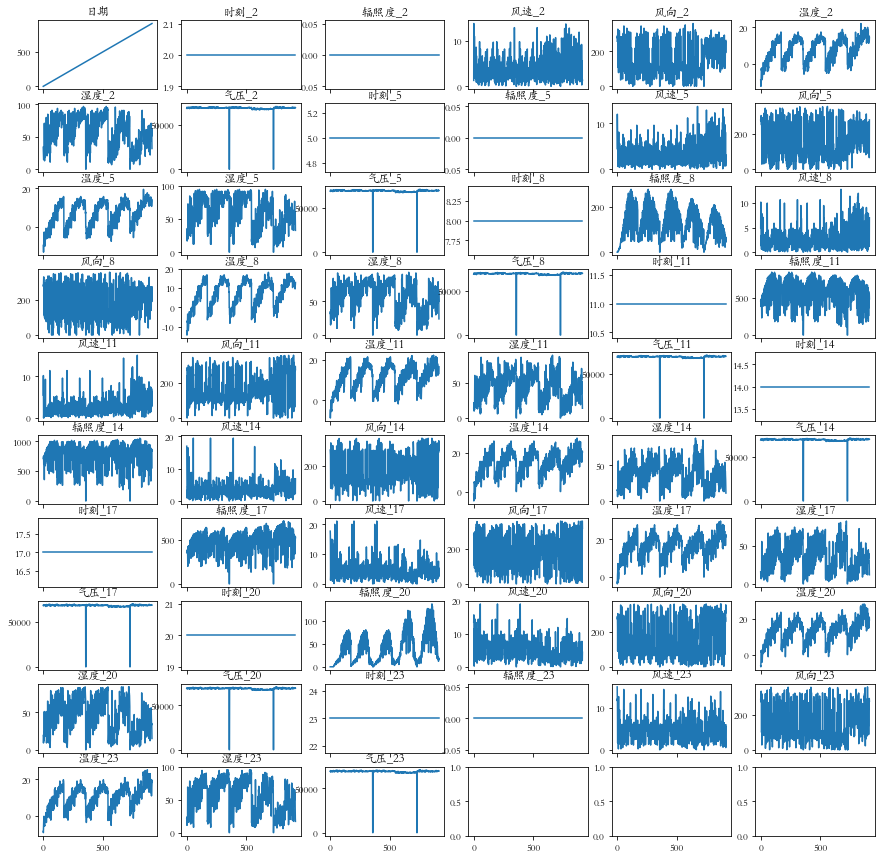

In [198]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=10, ncols=6, sharex=True,figsize=(15, 15))
plot_id = 0
for label in test_label_df.columns:
    col = int(plot_id/6)
    row = plot_id - col*6
    ax = axs[col][row]
    ax.plot(test_label_df[label])
    ax.set_title(label)
    plot_id += 1

### prediction

In [29]:
test_label_df = add_new_features(test_label_df)
test_label_df = polynomial_feature_col(test_label_df)
test_label_df.to_csv('test_feature_added.csv', index=False)

In [5]:
test_label_df = pd.read_csv('test_feature_added.csv')

In [30]:
test_label_df.columns

Index(['日期', '时刻_2', '辐照度_2', '风速_2', '风向_2', '温度_2', '湿度_2', '气压_2', '时刻_5',
       '辐照度_5',
       ...
       '湿度_风速_23', '湿度_风向_23', '湿度_温度_23', '湿度_湿度_23', '湿度_气压_23', '气压_风速_23',
       '气压_风向_23', '气压_温度_23', '气压_湿度_23', '气压_气压_23'],
      dtype='object', length=344)

In [32]:
x_test = test_label_df[fcol].values
#x_test = poly.fit_transform(x_test)
x_test = 1 - ((maxs - x_test) / rng)
np.save('x_test.npy', x_test)
x_test.shape

(912, 332)

In [49]:
predict = xgb_up.predict(x_test)

In [51]:
#yy = xgb_up.predict(X)
#predict = (predict - yy.min())/(yy.max() - yy.min())
predict[predict > 1] = 1

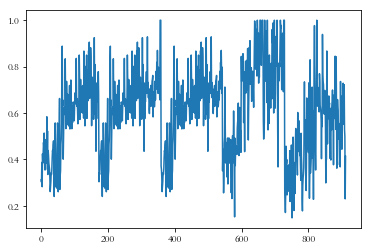

In [52]:
plt.plot(predict)

### make submission

In [53]:
data = np.array([np.arange(1, 913)]).T
submission_df = pd.DataFrame(data, index=index, columns=columns)
submission_df['prediction'] = predict
submission_df.rename(columns={'日期':'time'}, inplace=True)
submission_df.to_csv('submission2.csv', index=False)

### 2018/10/26 Error analysis
- xgb_up = XGBClassifier(n_jobs=4,n_estimators=300,max_depth=3,eta=0.15)
- score former 100 : 0.145                     
- part of the predictions are good, parts are extremely bad --- overlapping ??

### 2018/10/26 Error analysis 2
- xgb_up = XGBClassifier(n_jobs=4,n_estimators=500,max_depth=5,eta=0.15,objective='binary:logistic',min_child_weight=4,predictor='gpu_predictor',silent= True)
- score former 100 : 0.3
- wind of 8 and 2 become more important feature than before (radio 11 7 was more important)
### the problem is that I used a classifier               

### 2018/10/27 Score
- xgb_up = xgboost.XGBRegressor(n_jobs=4,n_estimators=100,max_depth=2,learning_rate=0.1,
objective='binary:logistic',min_child_weight=1,tree_method='gpu_hist',silent= True)
- score 0.19
- seems better